## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">Esh: A Novel Activation Function for Improved Neural Network Performance</p>

Activation functions play a crucial role in the performance of neural networks by introducing non-linearity and allowing the network to learn complex relationships in the data. In this paper, we present Esh, a new activation function that is designed to improve the accuracy and efficiency of neural networks. 

Esh is defined as the hyperbolic tangent (tanh) of the sigmoid function applied to the input x and is based on the popular Mish function, but with a more gradual slope that helps it to better retain low-level features in the input data.
Esh is defined to be

$$
\text{Esh}(x) = x \tanh(\text{sigmoid}(x))
$$
where $\text{sigmoid}(x)=1/(1+e^{-x})$.

<br>

<br>
<center>
<img src='https://i.postimg.cc/HLcZVRHV/Novel-AFs-V1.png' width=650> 
<figcaption>Proposed AFs</figcaption>
<br>
<br>

To evaluate the effectiveness of Esh, we conducted experiments using a convolutional neural network (CNN) trained on the CIFAR-10 dataset, as well as the VGG16 and ResNet20 architectures on the ImageNet dataset. We compared the performance of Esh to the ReLU, Swish, and Mish activation functions as baselines.
    
<br>
<center>
<img src='https://i.postimg.cc/NGHFRPbY/AFs-Known.png'
<figcaption>Proposed Esh vs Other AFs</figcaption>
<br>    

In [ ]:
!pip install livelossplot
!pip install tensorflow-addons 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">Implementation</p>

In [ ]:
from keras.applications import VGG16
from keras.layers import Activation
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import tensorflow.keras as keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import cifar100, cifar10
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils.generic_utils import get_custom_objects
from keras.activations import swish, leaky_relu, relu, gelu, elu, selu

import pandas as pd
import numpy as np
import time
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', font_scale=1.6, rc={"figure.dpi":250, 'savefig.dpi':250})

from livelossplot.inputs.keras import PlotLossesCallback

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

In [ ]:
# Set random seeds
def set_seed(seed=2):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the Esh activation function
def esh(x):
    return x * K.tanh(K.sigmoid(x))

def mish(x):
    return tfa.activations.mish(x)

get_custom_objects().update({'mish': Activation(mish)})
get_custom_objects().update({'esh': Activation(esh)})

#### Grid
xx = np.linspace(start=-3,stop=3,num=100)
afs = [esh, swish, mish, gelu, elu, leaky_relu, relu, softplus, softsign]

#### Plot activation functions
plt.figure(figsize=(10,8))
for i, act_fuct in enumerate(afs):
    c = 'c'
    if act_fuct.__name__ == 'esh':
        c = 'orange'
    plt.subplot(4,3,i+1)
    plt.plot(xx,act_fuct(xx), color=c, linewidth=1)
    plt.plot(xx,esh(xx), color='orange', linewidth=1)
    plt.axhline(color='black')
    plt.axvline(color='black')
    plt.title(act_fuct.__name__)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
sns.despine(bottom=True,left=True)
plt.show()

In [ ]:
#settings
img_shape = (32, 32, 3)
batch_size = 128
n_classes = 100
epochs = 200
version_string = 'v2_cifar100'

from keras.optimizers import SGD
optimizer = Adam() #SGD(learning_rate=0.01, momentum=0.9) #

loss = 'categorical_crossentropy'
metrics = ['accuracy']
verbose=1
early_stop_patience = epochs

gd_path = '/content/drive/MyDrive/Project/'

# create a list of activation functions to test
activation_functions = ['esh', 'mish','swish','leaky_relu', 'relu', 'gelu', 'elu','selu']

In [ ]:
# load the dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Scale the pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = np_utils.to_categorical(y_train, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

169001437/169001437 [==============================] - 22s 0us/step


In [ ]:
def build_model(weight_decay=0.0005, act_func = 'relu'):
    # Build the network of vgg for 100 classes with massive dropout and weight decay as described in the paper.

    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=img_shape,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    model.summary()
    return model

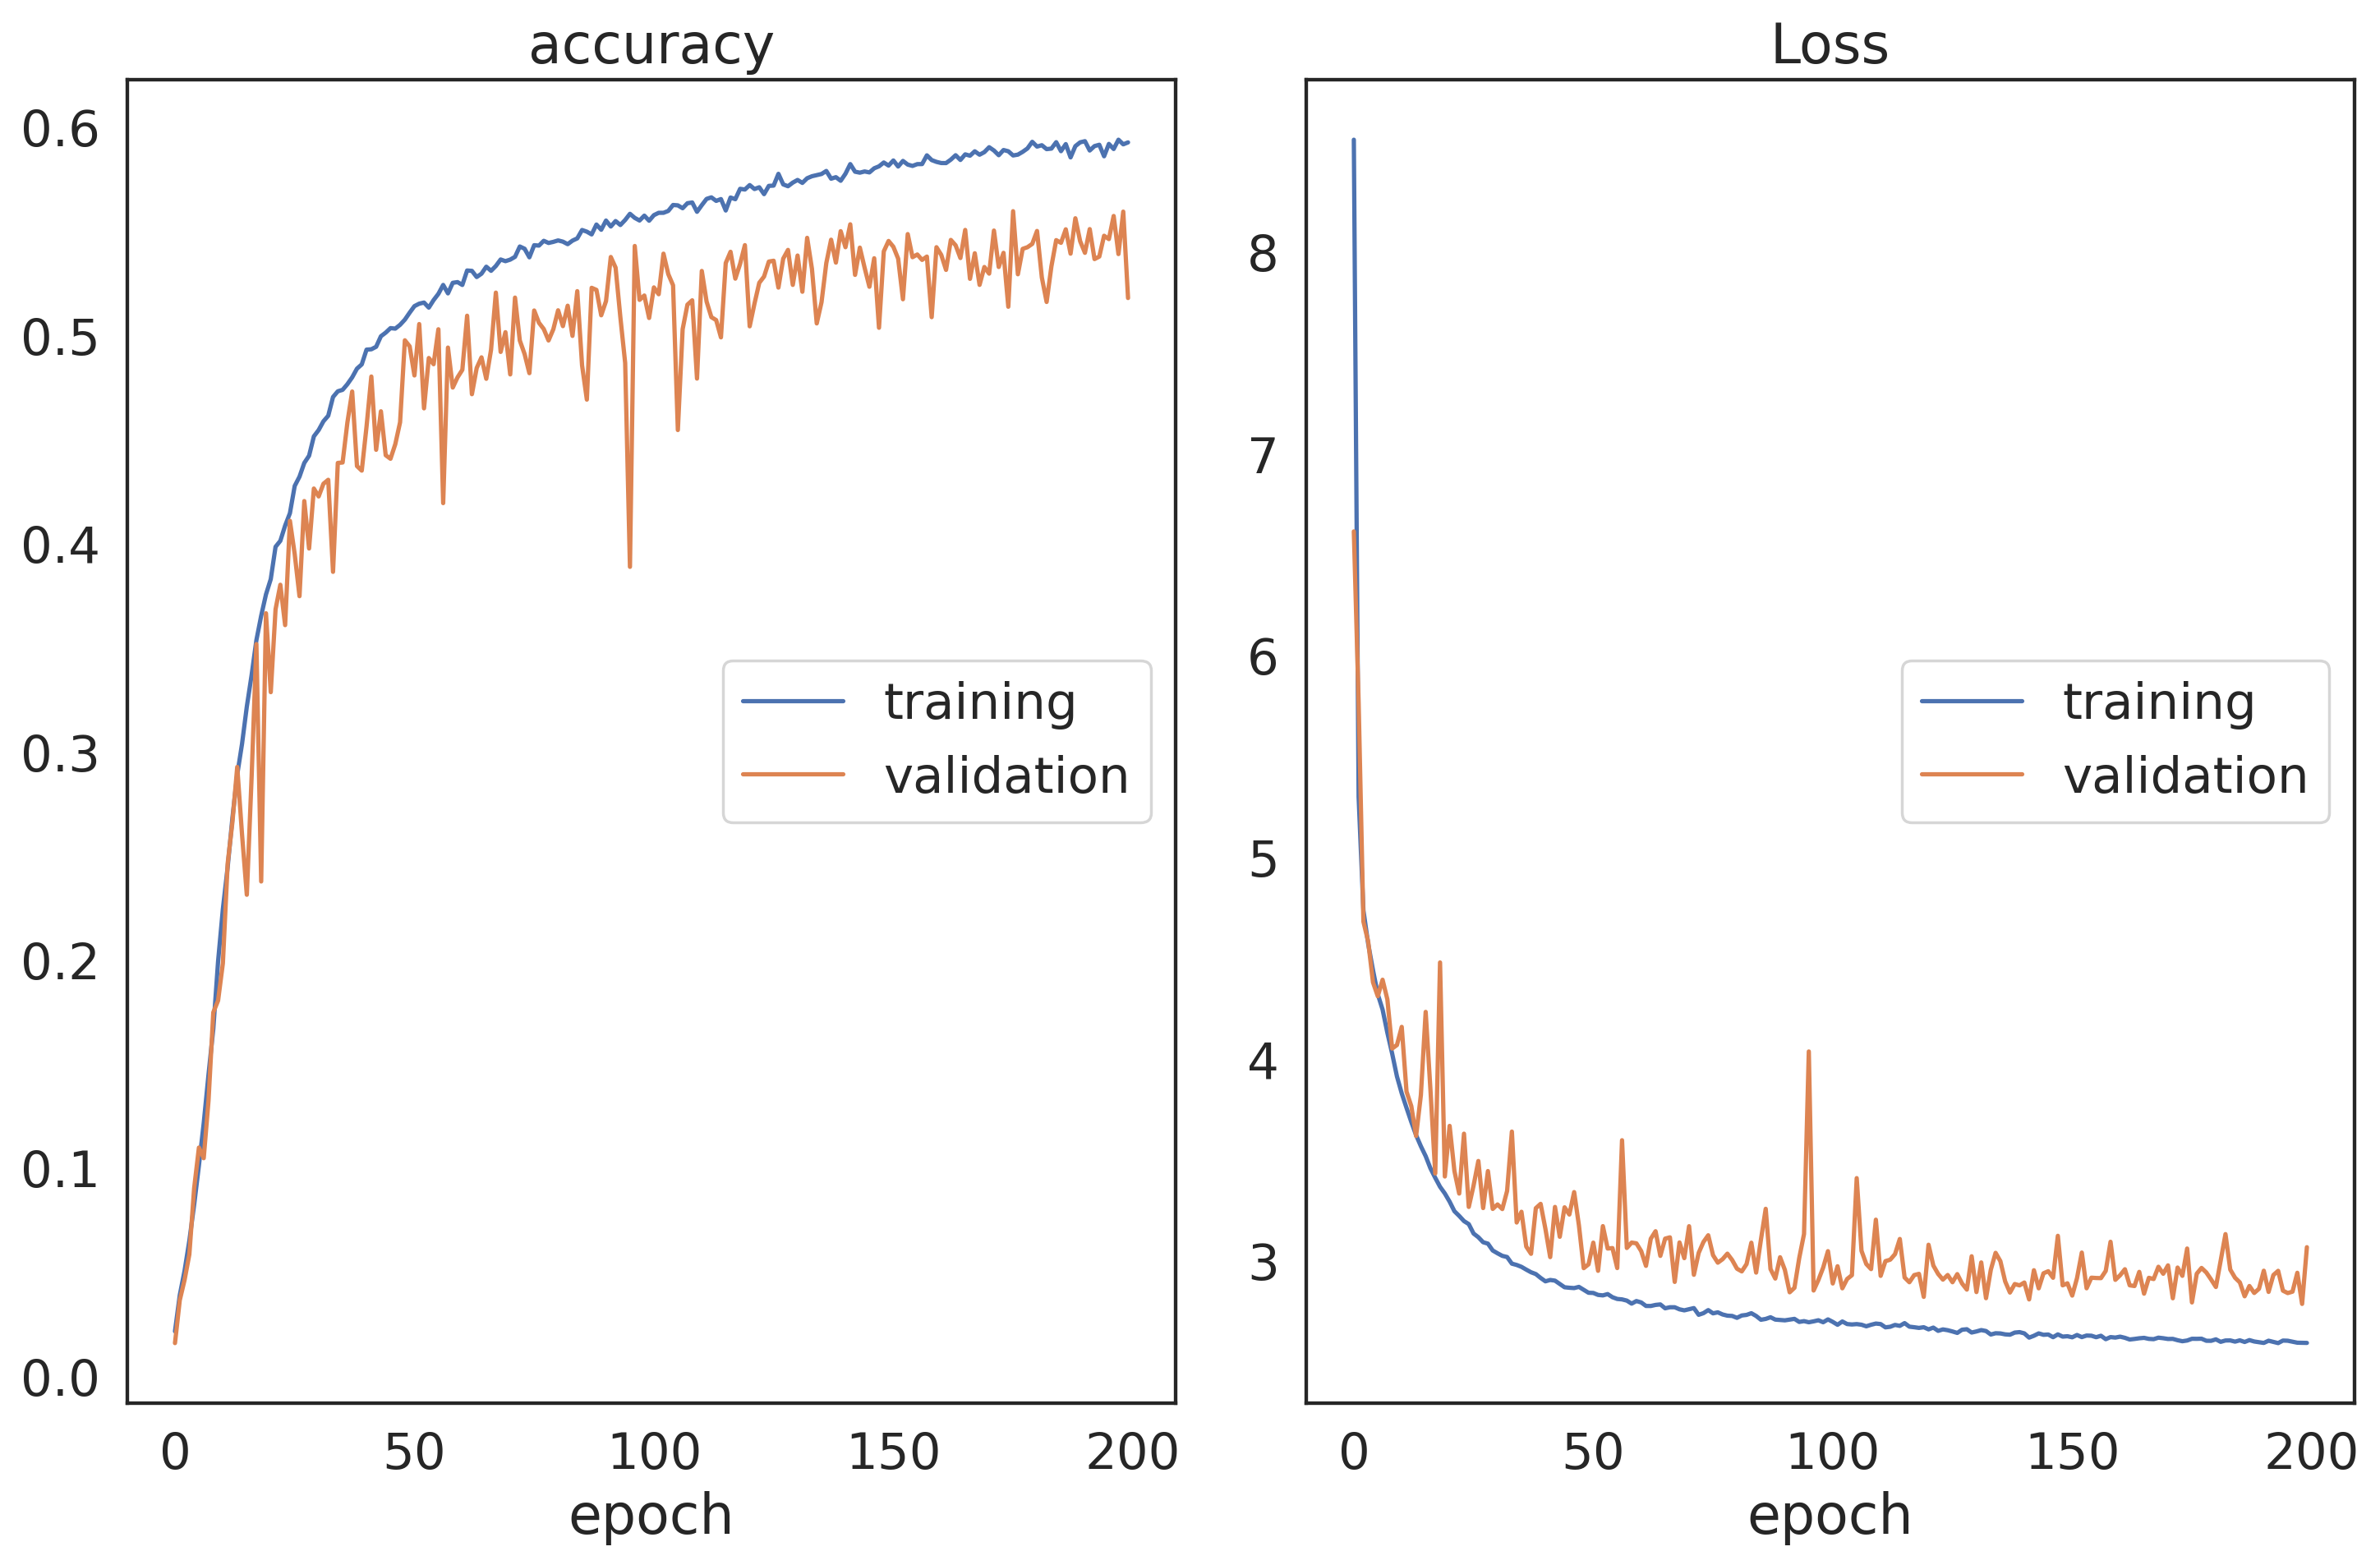

accuracy
	training         	 (min:    0.021, max:    0.594, cur:    0.592)
	validation       	 (min:    0.016, max:    0.559, cur:    0.518)
Loss
	training         	 (min:    2.589, max:    8.555, cur:    2.590)
	validation       	 (min:    2.783, max:    6.613, cur:    3.065)
391/391 [==============================] - 31s 79ms/step - loss: 2.5902 - accuracy: 0.5924 - val_loss: 3.0646 - val_accuracy: 0.5177
  Activation Function  Train Loss  Val Loss  Train Acc    Val Acc  \
0                 esh    2.247395  2.912579  73.070002  58.329999   
1                mish    2.260616  2.878393  69.980001  57.059997   
2               swish    2.144253  2.750502  72.053999  58.270001   
3          leaky_relu    2.196418  2.562621  60.956001  53.320003   
4                relu    2.254867  2.800678  69.019997  57.010001   
5                gelu    2.293152  2.868757  69.620001  57.050002   
6                 elu    2.146086  2.743286  70.047998  57.239997   
7                selu    2.231525  2.

In [9]:
# create the VGG16 model

from tensorflow.keras.applications.vgg16 import preprocess_input
printModel = True

vgg_x_train = x_train
vgg_x_test = x_test

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
#vgg16_model.summary()

# create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Activation Function', 'Train Loss', 'Val Loss', 'Train Acc', 'Val Acc', 'Exec Time(min)',

                                  'Misc'])
models = {} 
for act_func in activation_functions:
    tf.keras.backend.clear_session()
    # add the desired activation function to the model
    #vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
    start=time.time()
    #model = keras.Sequential()
    #model.add(vgg16_model)
    #model.add(layers.Flatten())
    #model.add(layers.Dense(512))
    #model.add(layers.Activation(act_func))
    #model.add(layers.Dense(512))
    #model.add(layers.Activation(act_func))
    #model.add(layers.BatchNormalization())
    #model.add(layers.Dropout(0.5))
    #model.add(layers.Dense(n_classes, activation='softmax'))
    
    ## Freeze the layers of VGG16 model
   #for layer in vgg16_model.layers:
        #layer.trainable = False

    model = build_model(weight_decay=0.0005, act_func = act_func)
        
    if printModel:
        model.summary()
        printModel=False
        
    print(act_func)

    # train the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    #Plot losses
    plot_loss = PlotLossesCallback()
    
    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss',
                           patience = early_stop_patience,
                           restore_best_weights = True,
                           mode='min')
    
    # save best model
    checkpointer = ModelCheckpoint(filepath=f"{gd_path}best_model_{act_func}_{version_string}.tf",
                               verbose=verbose, save_best_only=True)
    
    history = model.fit(vgg_x_train, y_train, epochs=epochs, 
                        batch_size=batch_size, validation_data=(vgg_x_test, y_test), 
                        callbacks=[checkpointer, early_stop, plot_loss])
    
    models[act_func] = model
    stop=time.time()
    exec_time = np.round((stop-start)/60, 2)
    # Load the best model
    model.load_weights(f'{gd_path}best_model_{act_func}_{version_string}.tf')
    
    # evaluate the model
    final_train_loss, final_train_acc = model.evaluate(vgg_x_train, y_train, verbose=0)
    final_val_loss, final_val_acc = model.evaluate(vgg_x_test, y_test, verbose=0)

    # save the results
    results_df = results_df.append({'Activation Function': act_func,
                                   'Train Loss': final_train_loss,
                                   'Val Loss': final_val_loss,
                                   'Train Acc': 100*final_train_acc,
                                   'Val Acc': 100*final_val_acc,
                                   'Exec Time(min)': exec_time,
                                   'Misc': f"epochs_{epochs}"}, ignore_index=True)
    # Save the training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f"{gd_path}history_{act_func}_{version_string}.csv", index=False)
    
    # Print the results dataframe
    print(results_df)

    # Save the results dataframe to a CSV file
    results_df.to_csv(f"{gd_path}results_{act_func}_{version_string}.csv", index=False)
    #plot_loss.reset_outputs()


In [10]:
models

{'esh': <keras.engine.sequential.Sequential at 0x7f46108da130>,
 'mish': <keras.engine.sequential.Sequential at 0x7f45334f1ac0>,
 'swish': <keras.engine.sequential.Sequential at 0x7f45325ff880>,
 'leaky_relu': <keras.engine.sequential.Sequential at 0x7f43fa999970>,
 'relu': <keras.engine.sequential.Sequential at 0x7f4400b05850>,
 'gelu': <keras.engine.sequential.Sequential at 0x7f43fbc620d0>,
 'elu': <keras.engine.sequential.Sequential at 0x7f4534760580>,
 'selu': <keras.engine.sequential.Sequential at 0x7f43fcb807f0>}

In [11]:
results_df

,Activation Function,Train Loss,Val Loss,Train Acc,Val Acc,Exec Time(min),Misc
0,esh,2.247395,2.912579,73.070002,58.329999,119.44,epochs_200
1,mish,2.260616,2.878393,69.980001,57.059997,119.96,epochs_200
2,swish,2.144253,2.750502,72.053999,58.270001,118.43,epochs_200
3,leaky_relu,2.196418,2.562621,60.956001,53.320003,106.40,epochs_200
4,relu,2.254867,2.800678,69.019997,57.010001,104.34,epochs_200
5,gelu,2.293152,2.868757,69.620001,57.050002,135.44,epochs_200
6,elu,2.146086,2.743286,70.047998,57.239997,106.21,epochs_200
7,selu,2.231525,2.783441,67.927998,55.919999,107.43,epochs_200
